In [1]:
%matplotlib ipympl
import os 
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker
from IPython.display import display
import pandas as pd
import numpy as np
import math
from shapely.geometry import Point, Polygon, MultiPoint
import matplotlib.patches as patches
import shapely.speedups
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix
shapely.speedups.enable() 

In [3]:
fp = '../PL/'
pucks = {
'SW6':  fp + "SW6_jun14_pl.csv",
'F03':  fp + "F03_jun14_pl.csv",
'SW30':  fp + "SW30_jun14_pl.csv",
'SW31':  fp + "SW31_jun14_pl.csv",
'SW33':  fp + "SW33_jun14_pl.csv",
'SW55':  fp + "SW55_jun14_pl.csv",    
'SW56':  fp + "SW56_jun14_pl.csv",        
}
for p in pucks:
    pucks[p] = pd.read_csv(pucks[p],index_col=0)

In [4]:
fp = '../BC/'
selbc = {}
outf = 'bc_apr_1'
for p in pucks.keys():
    selbc[p] = [x.strip() for x in open(fp + '{}_{}.csv'.format(p,outf),'r').readlines()]
    if p=='SW6':
        selbc[p] = [x.strip() for x in open(fp + '../BC/SW6_bc.csv','r').readlines()]
    pucks[p] = pucks[p].assign(sel = 0)
    pucks[p].sel[pucks[p].index.isin(selbc[p])] = 1
    

/var/folders/c3/7p4q46xs3yv4_jgf7k4qf_3w0000gn/T/ipykernel_21266/3843994849.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pucks[p].sel[pucks[p].index.isin(selbc[p])] = 1


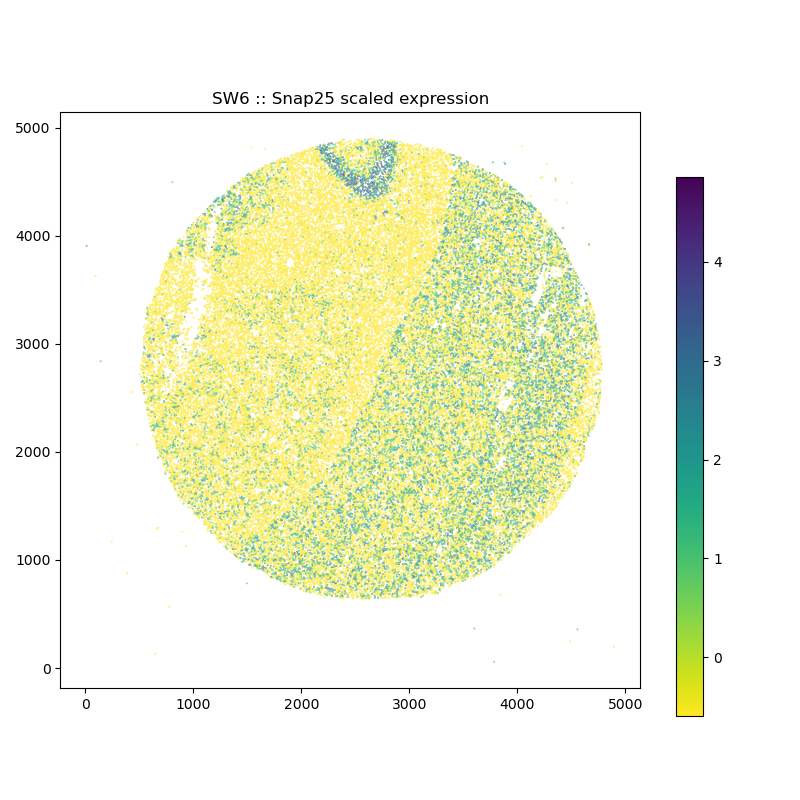

In [12]:
plt.close('all')
plt.rcParams["figure.figsize"] = (8,8)
gene = 'Snap25'
for p in pucks:
    if p!='SW6':
        continue
    fig, ax = plt.subplots()
#     ax.scatter(pucks[p].x, pucks[p].y, c = pucks[p].sel, cmap = 'hot',s=.1)
#     my_c = 
#     my_c = [0 if x< 0 else x for x in my_c ]
    neg = ax.scatter(pucks[p].x, pucks[p].y, c = pucks[p][gene],s=.1,cmap='viridis_r')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'{p} :: Snap25 scaled expression')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)


    plt.tight_layout()
    plt.savefig(f'./FIGURES/{p}_snap25_puck.pdf')


In [5]:
pldfs = {}
path = '../PLDF/'
for x in os.listdir(path):
    if '10x' in x:
        continue
    if 'csv' not in x:
        continue
    p = x.split('_')[0]
    pldfs[p] = pd.read_csv('{}{}'.format(path,x), header=0, index_col=0)

In [38]:
# plt.close('all')
# print(pldfs[p].shape)
# print(pldfs[p][pldfs[p].index.isin(selbc[p])].shape)
# pldfs[p] = pldfs[p][pldfs[p].index.isin(selbc[p])]

(14307, 5)
(7674, 5)


In [6]:
exc_scheme = {'L2':'#CA9432','L2_3':'#CA9432',
             'L4':'#98A834',
             'L4_5':'#98A834',
              'L5':'#53B74C','L5_6':'#53B74C',
             'L6':'#4EB1D7',
             'L6b':'#CA78F0'}
exc_scheme = {'L2':'#EEEEEE','L2_3':'#EEEEEE',
             'L4':'#999999','L4_5':'#999999',
             'L5':'#555666','L5_6':'#555666',
             'L6':'#111111',
             'L6b':'#000000'}



In [7]:
excs = {}
for p in pldfs:
    pldfs[p] = pldfs[p][~pldfs[p].id.isin(['VLMC'])]
    pldfs[p] = pldfs[p].assign(mark=0)

    excs[p] = pldfs[p][pldfs[p].my_t=='EXC']
#     excs[p].L = [y if len(y)==2 else '{}_{}'.format(y[0:2],y[-1]) for y in [x.split(' ')[0] for x in excs[p].id]]
    excs[p].L = excs[p].L.replace('L6_b','L6b')
    excs[p] = excs[p].assign(c = [ exc_scheme[x] for x in excs[p]['L']])
    excs[p] = excs[p].assign(neb_1='', neb_2='',cnt_1=0, cnt_2=0, mark=1)

/tmp/ipykernel_60188/1418860485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excs[p].L = excs[p].L.replace('L6_b','L6b')
/tmp/ipykernel_60188/1418860485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excs[p].L = excs[p].L.replace('L6_b','L6b')
/tmp/ipykernel_60188/1418860485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [8]:
def top_neb(exc, limit_index):
    tmp = pd.DataFrame(distance_matrix(exc[['x', 'y']], exc[['x', 'y']], p=2))
    tmp.index = exc.index
    tmp.columns = exc.index
    res = tmp.apply(lambda x: x.nsmallest(n=21).index.to_list(), axis=1)
    res = pd.DataFrame(res)
    res.columns = ['neb']
    res.index = exc.index
    res.index = res.index.rename('bc')
    
    for x in res[exc.my_t.eq(limit_index)].index:
        ix = res.loc[x]
        neb = exc.loc[ix.to_list()[0]].L.value_counts()
        ls = neb.index.to_list()
        neb = neb.values
        exc.loc[x,'neb_1'] = ls[0]
        exc.loc[x,'cnt_1'] = neb[0]
        if len(ls)>1:
            exc.loc[x,'neb_2'] = ls[1]
            exc.loc[x,'cnt_2'] = neb[1]

    return exc

def rotate_plot(tpl, theta=180):
    theta = math.radians(theta)
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    tplp = np.dot(tpl[['x','y']],R)
    tplp = pd.DataFrame(tplp)
    tplp.columns = ['x','y']
    tpl = tpl.assign(rx = tplp.x.tolist())
    tpl = tpl.assign(ry = tplp.y.tolist())
    return(tpl)

In [9]:
sst_dfs = {}
for p in pldfs:
    exc = top_neb(excs[p],'EXC')
    exc.loc[exc[exc.L != exc.neb_1].index,'mark'] = 2
    
    pldfs[p].loc[exc.index,'mark'] = exc.mark
    excs[p] = exc
    
    sst_df = pldfs[p][pldfs[p].my_t.isin(['SST','EXC']) & pldfs[p].mark.ne(2)]
    sst_df = sst_df.assign(neb_1='', neb_2='',cnt_1=0, cnt_2=0)
    sst_df = top_neb(sst_df, 'SST')
    sst_dfs[p] = sst_df
    

In [10]:
sst_order = ['Sst Mme', 'Sst Calb2','Sst Hpse', 'Sst Etv1','Sst Myh8','Sst Syndig1l', 'Sst Crh','Sst Nmbr',
             'Sst Chodl','CHODL']

sst_scheme = {
'Sst Mme': '#08BD71',
'Sst Calb2': '#B99E00',
'Sst Hpse': '#75AF04',
'Sst Etv1': '#00BDCD',
'Sst Myh8': '#F562DE',
'Sst Syndig1l': '#06C0A4',
'Sst Crh': '#8FA903',
'Sst Nmbr': '#0AB2EE',
'Sst Chodl': '#C07FFF',
'CHODL': '#C07FFF'}


sst_pls = {}
for p in pldfs:
    sst_df = sst_dfs[p]
    sst_df = sst_df[sst_df.my_t.eq('SST')]
    sst_pls[p] = sst_df.assign(c=[sst_scheme[x] for x in sst_df.id.to_list()])
    sst_pls[p].id = sst_pls[p].id.replace('Sst-Chodl','CHODL')

In [18]:
# pucks[p][pucks[p].index.isin(pldfs[p][pldfs[p].my_t.eq('SST')].index.tolist())].Sst_umi.describe()
# pucks[p][pucks[p].index.isin(sst_pl.index)].Sst_umi
# sstu = pldfs[p][pldfs[p].Sst_umi.ge(1)]
# pldfs[p].Sst_umi[pucks[p][pucks[p].index.isin(sst_pl.index)]]

# pldfs.keys()


In [12]:
for p in pldfs:
    print(p)
    sst_pls[p].L[sst_pls[p].cnt_1.ge(sst_pls[p].cnt_2)] = sst_pls[p][sst_pls[p].cnt_1.ge(sst_pls[p].cnt_2)].neb_1
    sst_pls[p].L[~sst_pls[p].cnt_1.ge(sst_pls[p].cnt_2)] = sst_pls[p][~sst_pls[p].cnt_1.ge(sst_pls[p].cnt_2)].neb_2
    sst_pls[p].L = sst_pls[p].L.replace('L2','L2_3')

    sst_pls[p].id = sst_pls[p].id.replace('Sst Chodl','CHODL')
#     print(sst_pls[p].id.value_counts())

SW6
SW55
SW31
SW30
F03
SW56
SW33


/tmp/ipykernel_60188/3485912595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst_pls[p].L[sst_pls[p].cnt_1.ge(sst_pls[p].cnt_2)] = sst_pls[p][sst_pls[p].cnt_1.ge(sst_pls[p].cnt_2)].neb_1
/tmp/ipykernel_60188/3485912595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst_pls[p].L[~sst_pls[p].cnt_1.ge(sst_pls[p].cnt_2)] = sst_pls[p][~sst_pls[p].cnt_1.ge(sst_pls[p].cnt_2)].neb_2
/tmp/ipykernel_60188/3485912595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [13]:
plt.close('all')
plt.rcParams["figure.figsize"] = (15,15)
excl = ['L4','L6']

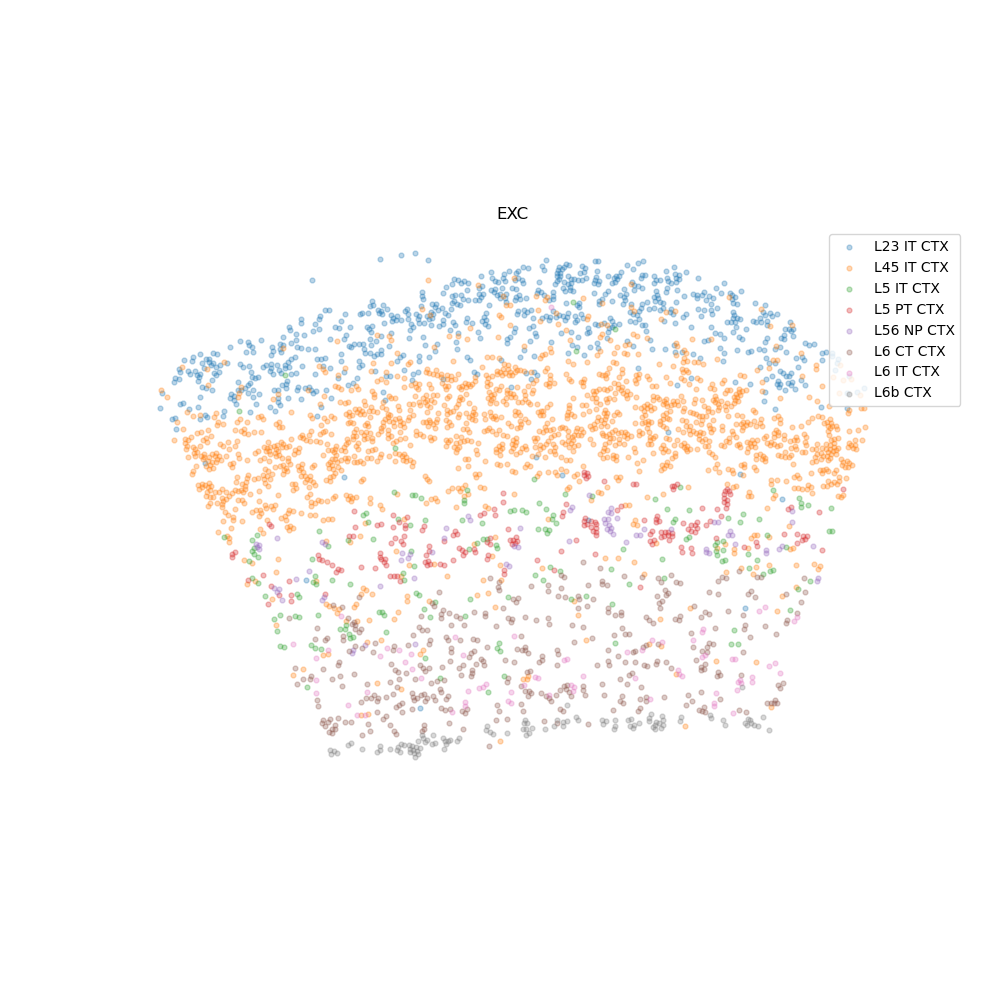

In [57]:
plt.close('all')
plt.rcParams["figure.figsize"] = (10,10)

# p='SW6'
# exc = excs[p]
# exc = exc[exc.index.isin(pucks[p].index[pucks[p].sel.eq(1)])]
# sst_pl = sst_pls[p]
# sst_pl = sst_pl[sst_pl.index.isin(pucks[p].index[pucks[p].sel.eq(1)])]

# sst_pl.id = sst_pl.id.astype("category")
# sst_pl.id = sst_pl.id.cat.set_categories(sst_order, ordered=True)
# exc.L = exc.L.replace('L6b','L6')
# exc.L = exc.L.replace('L2','L2_3')
# exc.L = exc.L.replace('L4_5','L4')
# exc.L = exc.L.replace('L5_6','L5')
# exc.L = exc.L.astype("category")
# exc.L = exc.L.cat.set_categories(['L2_3','L4','L5','L6'], ordered=True)

# exc.id = exc.id.astype("category")
plt.figure()
ax = plt.subplot()
for e in exc.id.cat.categories.values:
    tpl = exc[exc.id.eq(e) & exc.mark.isin([1,2])]
    tpl = rotate_plot(tpl, -120)
    ax.scatter(x=tpl.rx, y=tpl.ry,s=12,alpha=.3, label = e)
    ax.set_title('EXC')
    ax.axis('scaled')
    ax.axis('off')
    ax.legend(bbox_to_anchor=(.9, 1), loc='upper left')

plt.savefig('./FIGURES/{}_{}_{}_{}.pdf'.format('JUN20',p,'smrt','EXC'))




In [11]:
# exc = excs[p]
# exc.head()
# exc[exc.index.isin(pucks[p].index[pucks[p].sel.eq(1)])]
# pucks[p].loc['TCCATCGTCAGGCA']
# sum(exc.index.isin(pucks[p].index))
# sum(exc.index.isin(pucks[p].index))
# sst_pls['SW6'][sst_pls['SW6'].index.isin(selbc['SW6'])]
sst_pls.keys()

dict_keys(['SW6', 'SW55', 'SW31', 'SW30', 'F03', 'SW56', 'SW33'])

/tmp/ipykernel_60188/2129950619.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst_pl.id = sst_pl.id.astype("category")
/tmp/ipykernel_60188/2129950619.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst_pl.id = sst_pl.id.cat.set_categories(sst_order, ordered=True)
/tmp/ipykernel_60188/2129950619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

/tmp/ipykernel_60188/2129950619.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst_pl.id = sst_pl.id.cat.set_categories(sst_order, ordered=True)
/tmp/ipykernel_60188/2129950619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exc.L = exc.L.replace('L6b','L6')
/tmp/ipykernel_60188/2129950619.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

/tmp/ipykernel_60188/2129950619.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmppl.L = tmppl.L.replace('L6b','L6')
/tmp/ipykernel_60188/2129950619.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sst_pl['Sst_umi'] = 0
/tmp/ipykernel_60188/2129950619.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

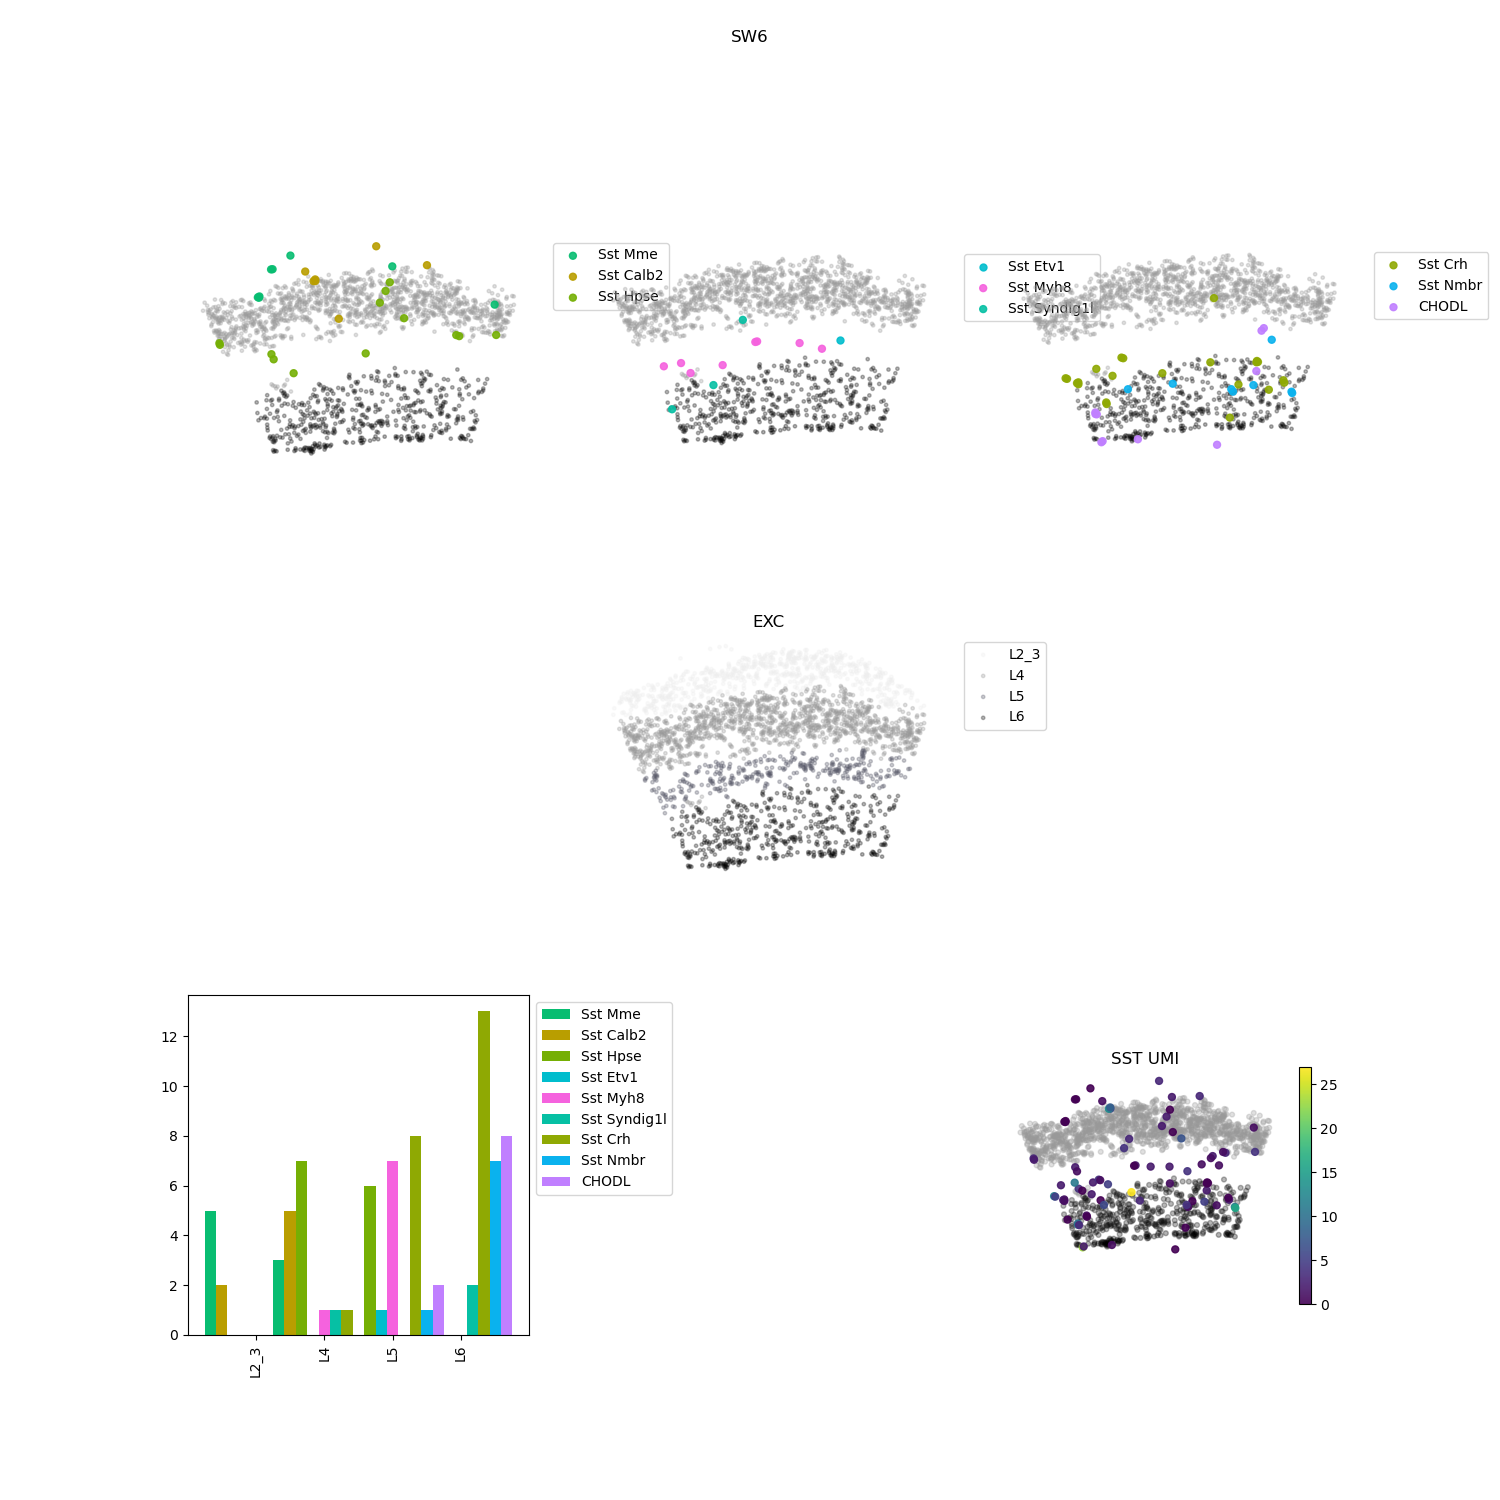

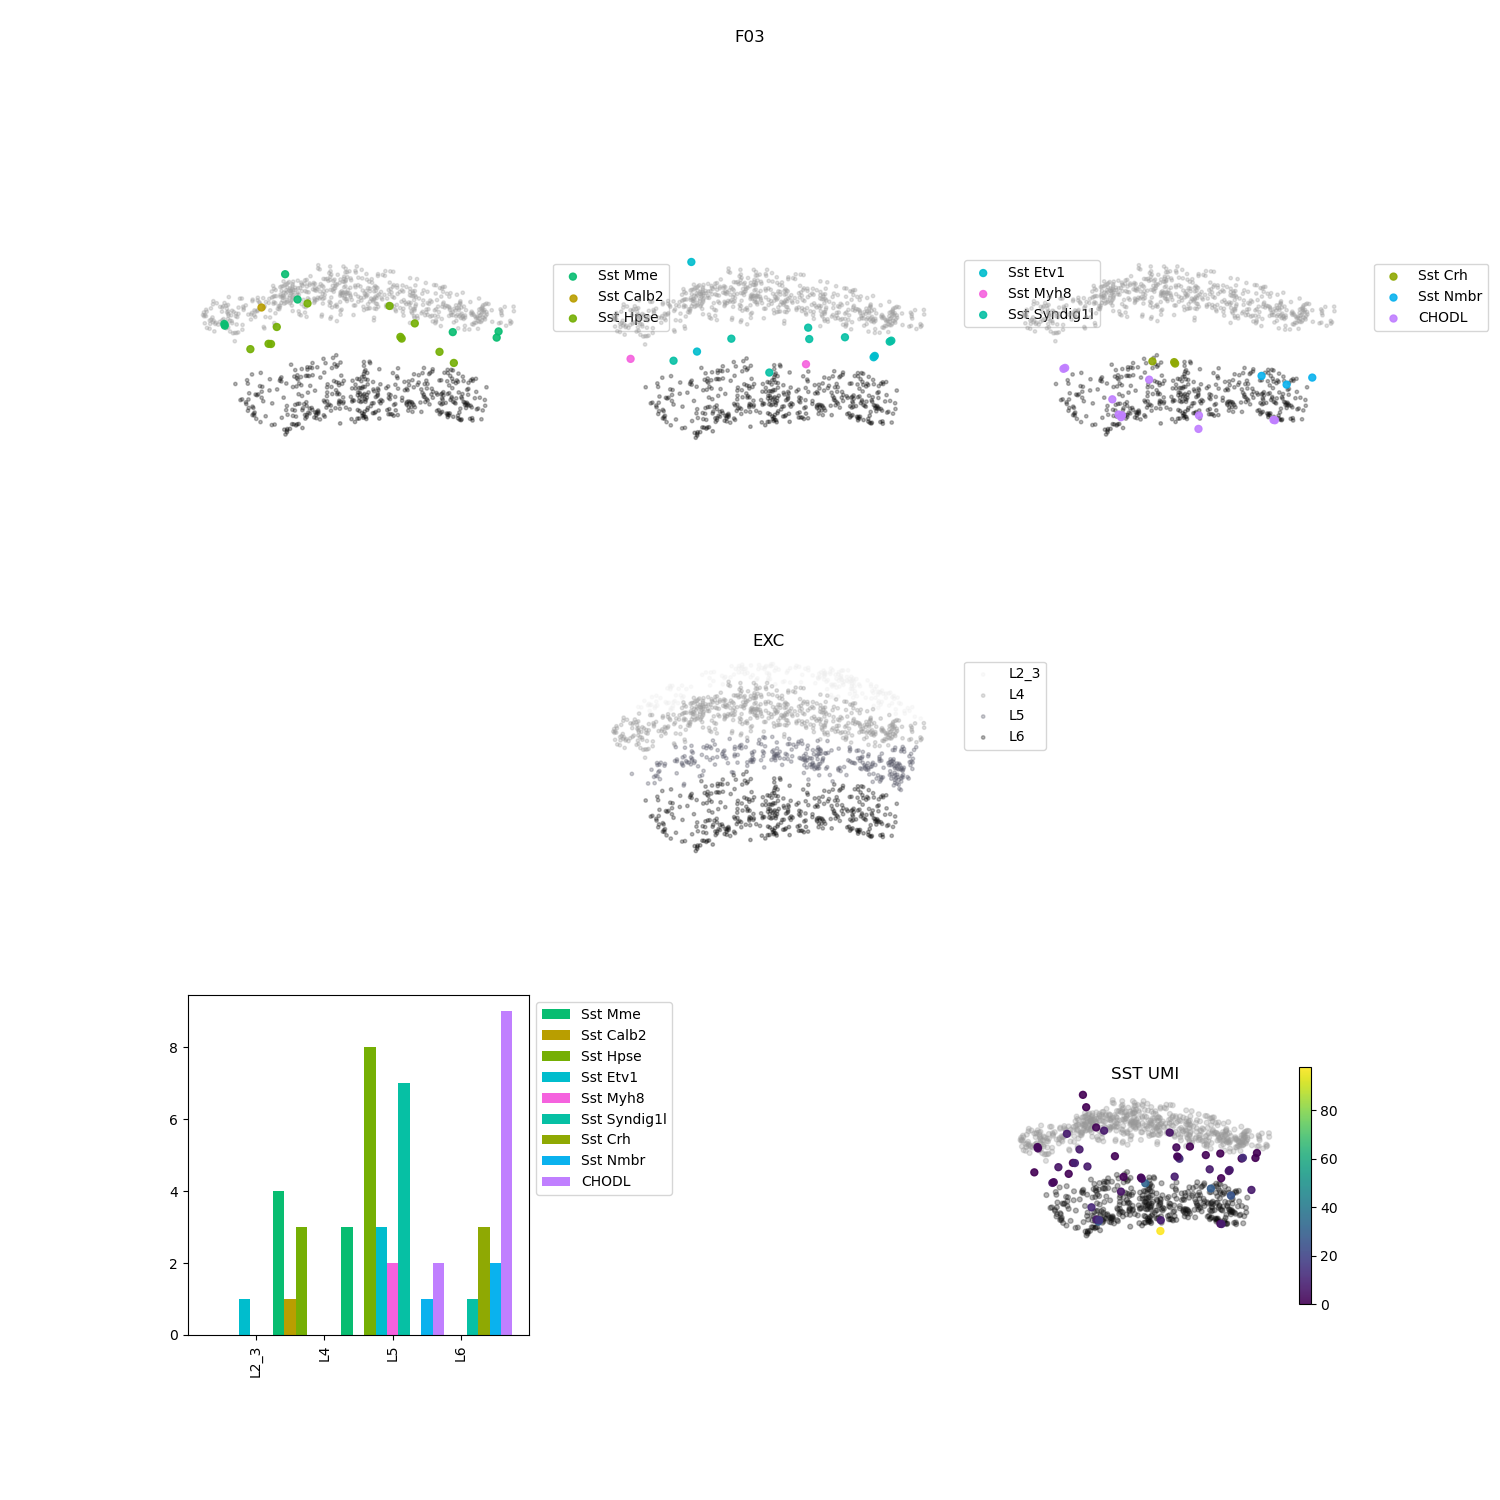

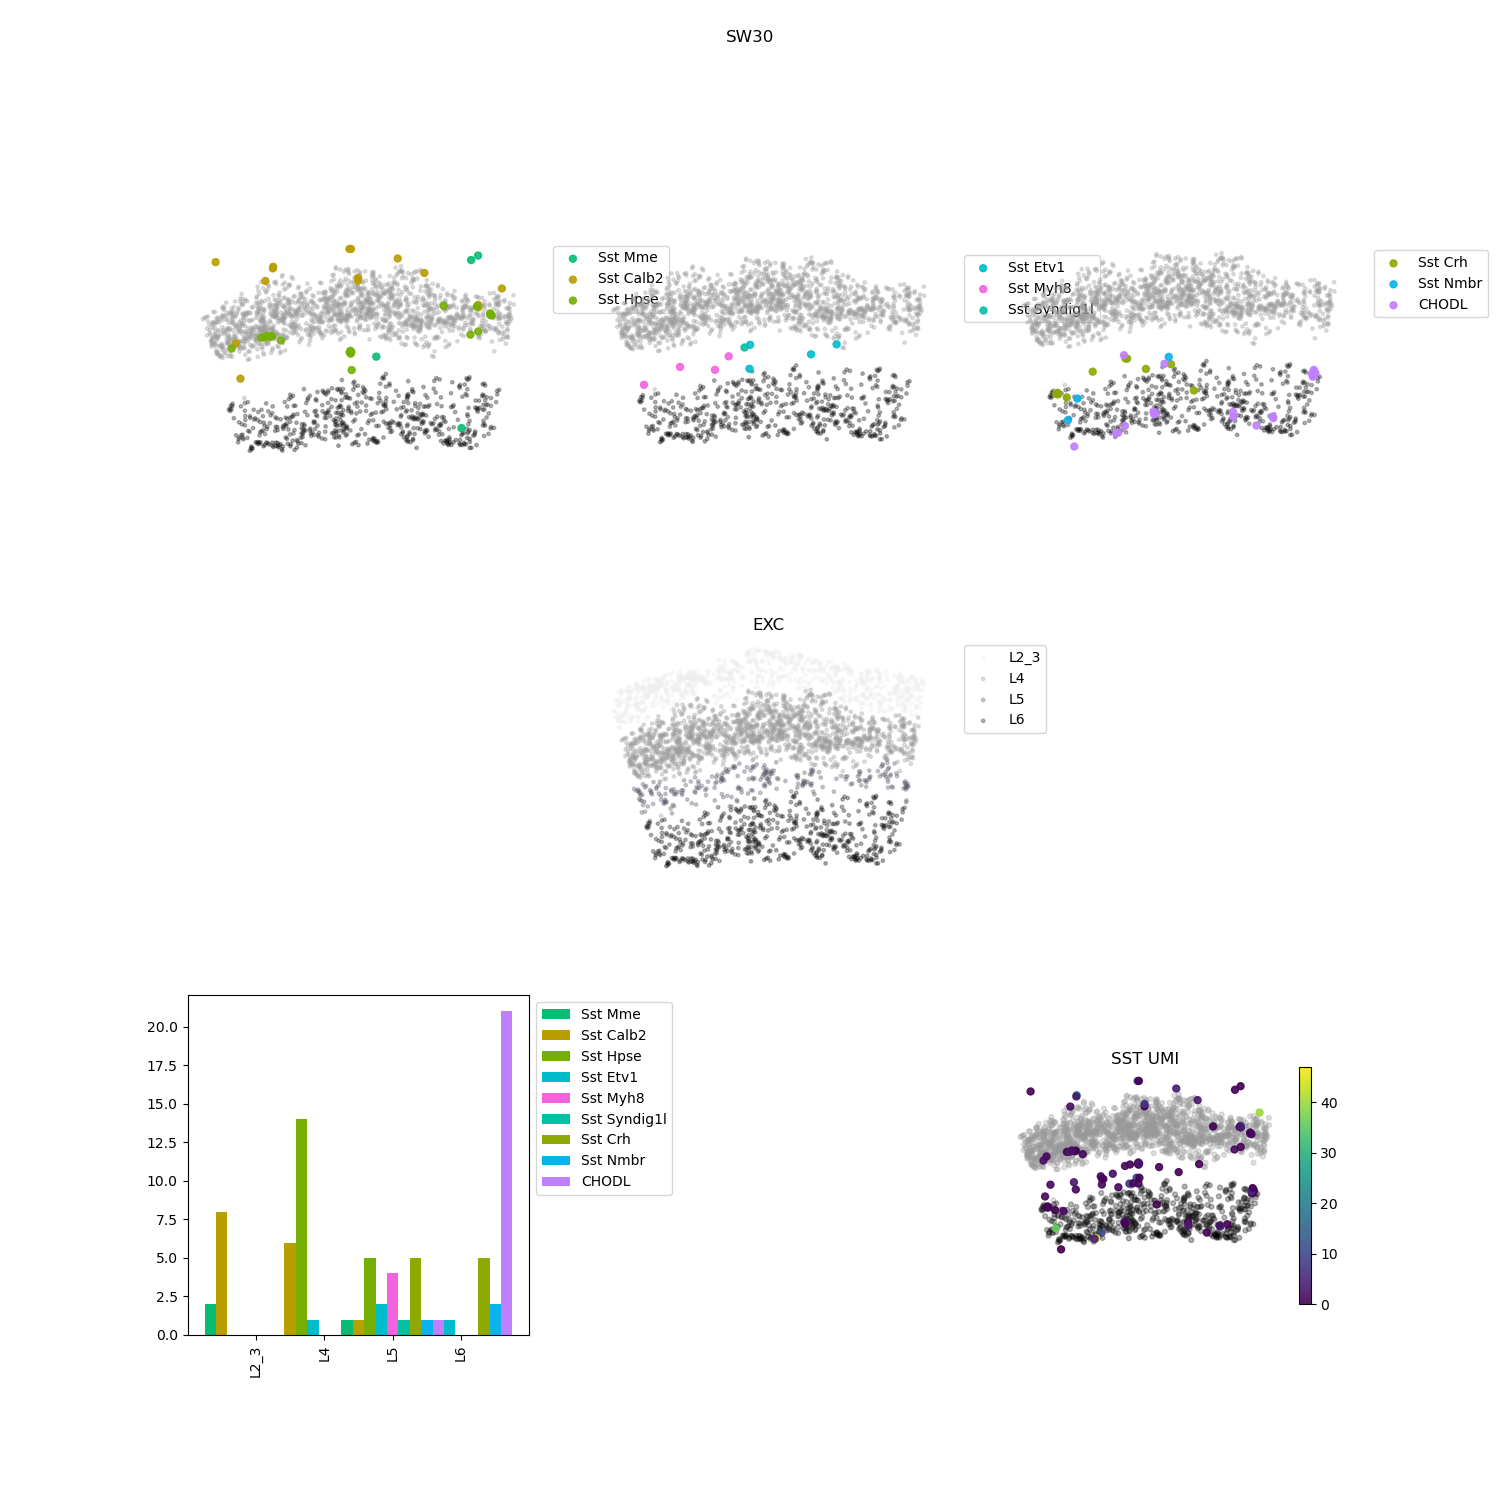

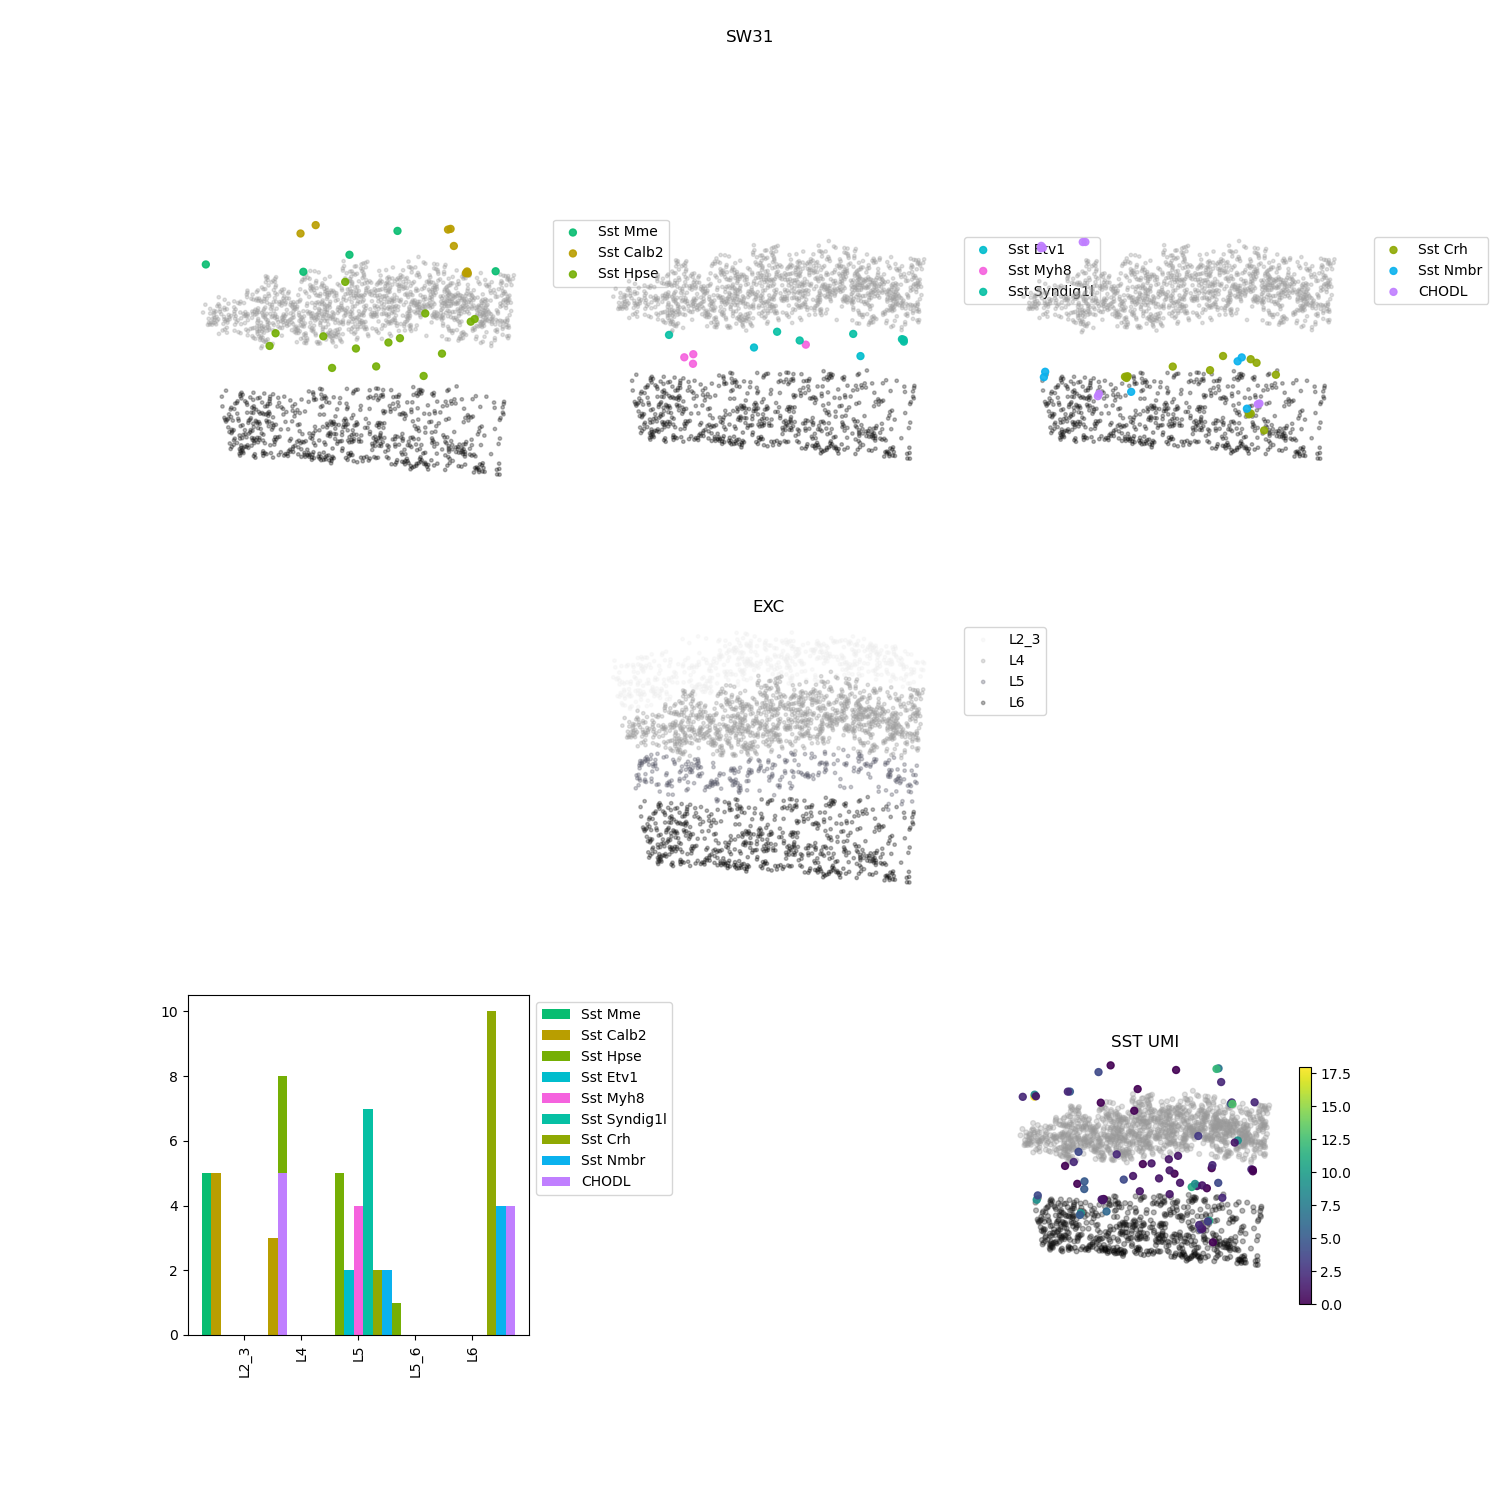

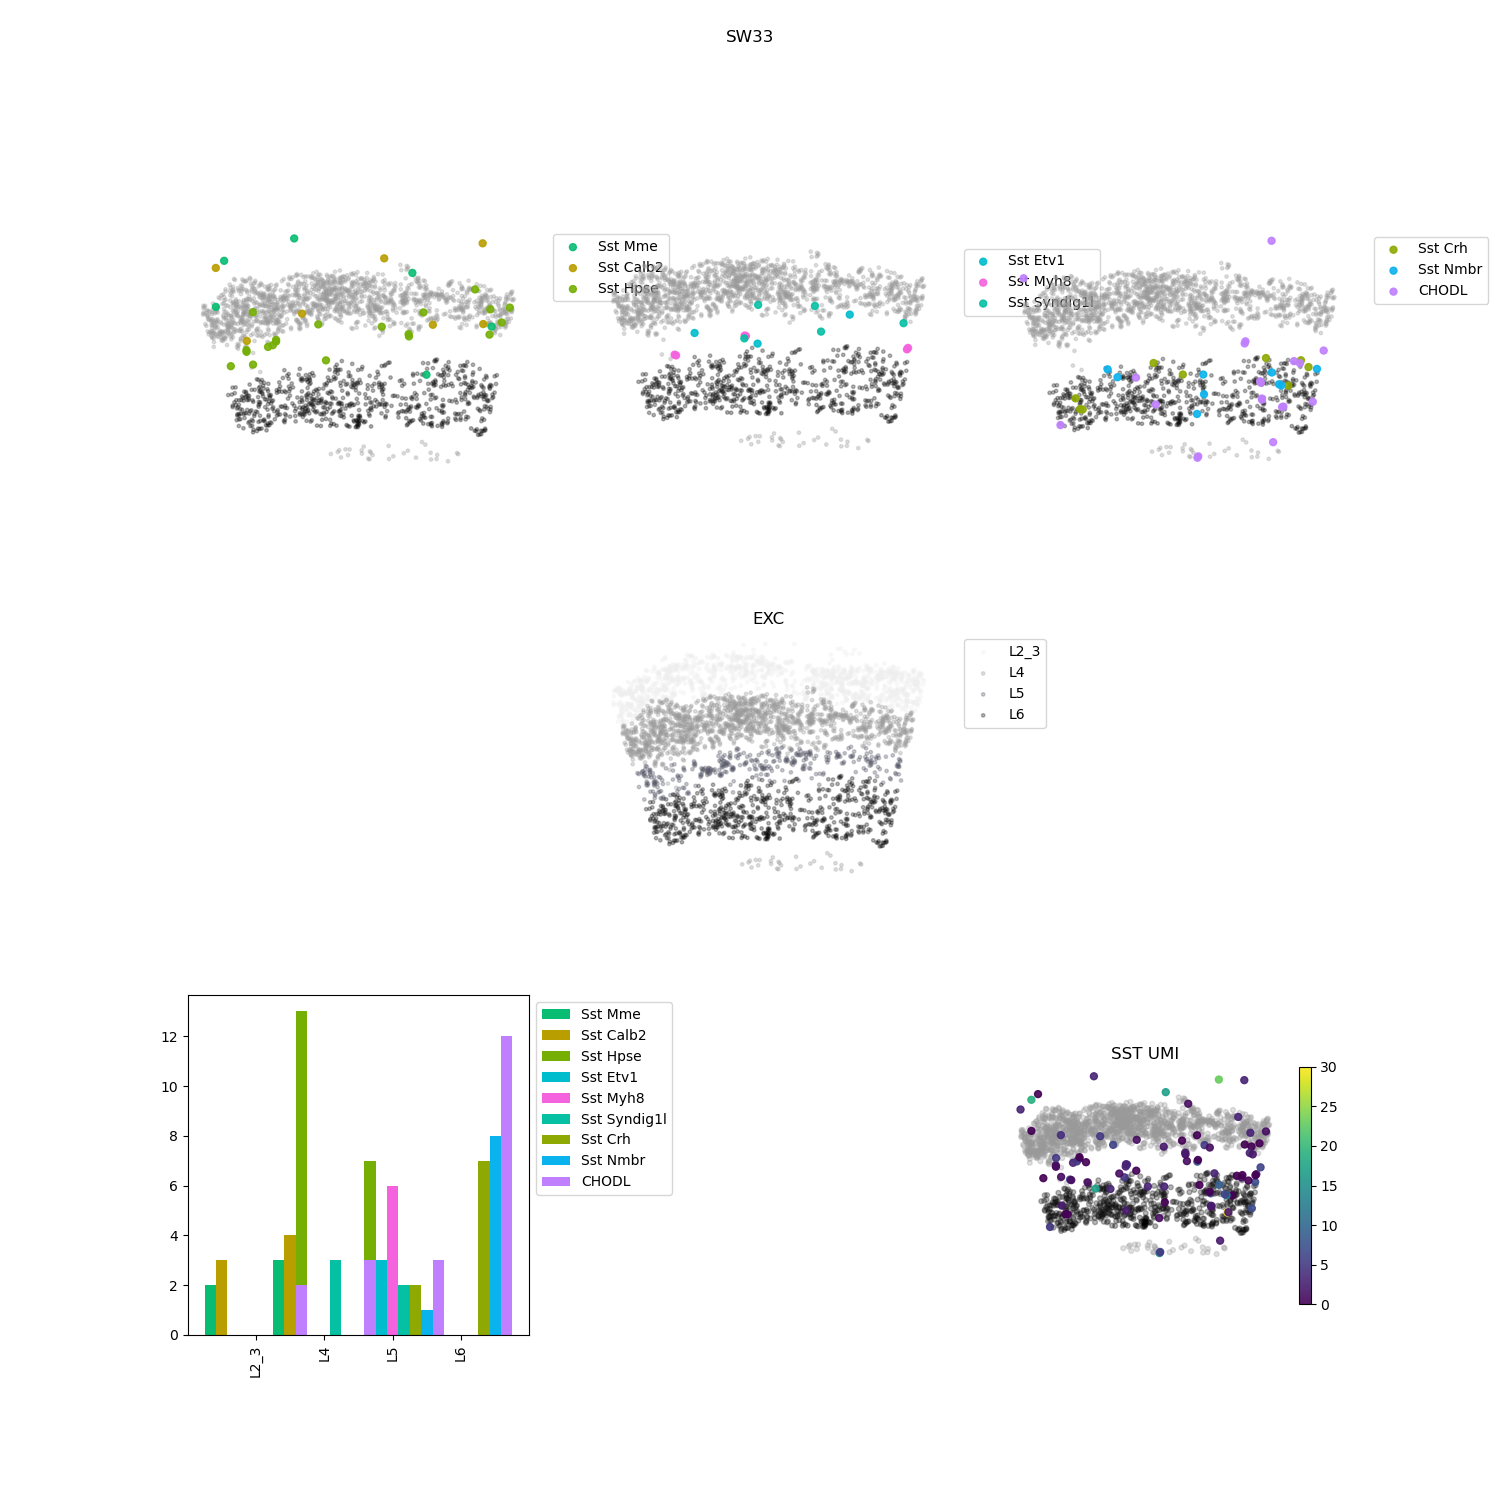

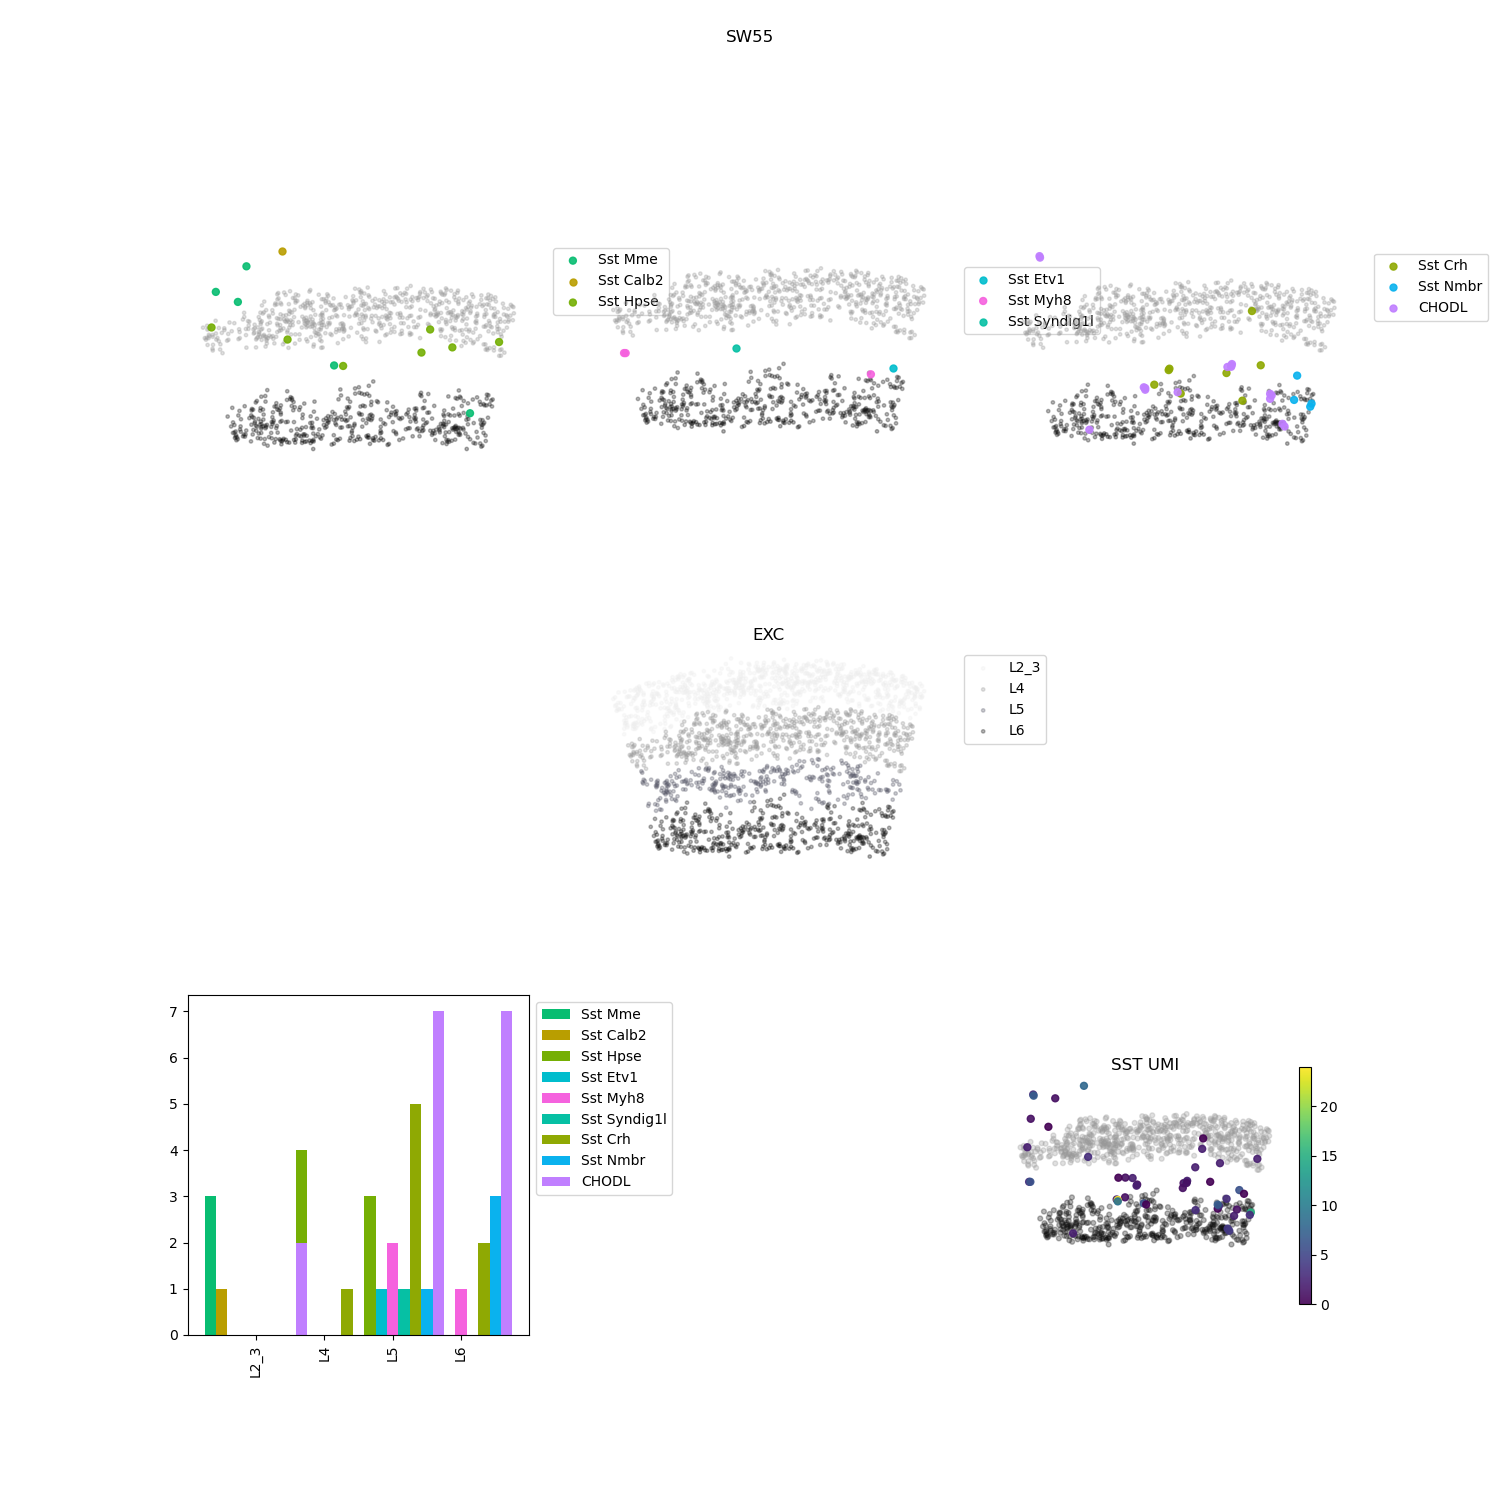

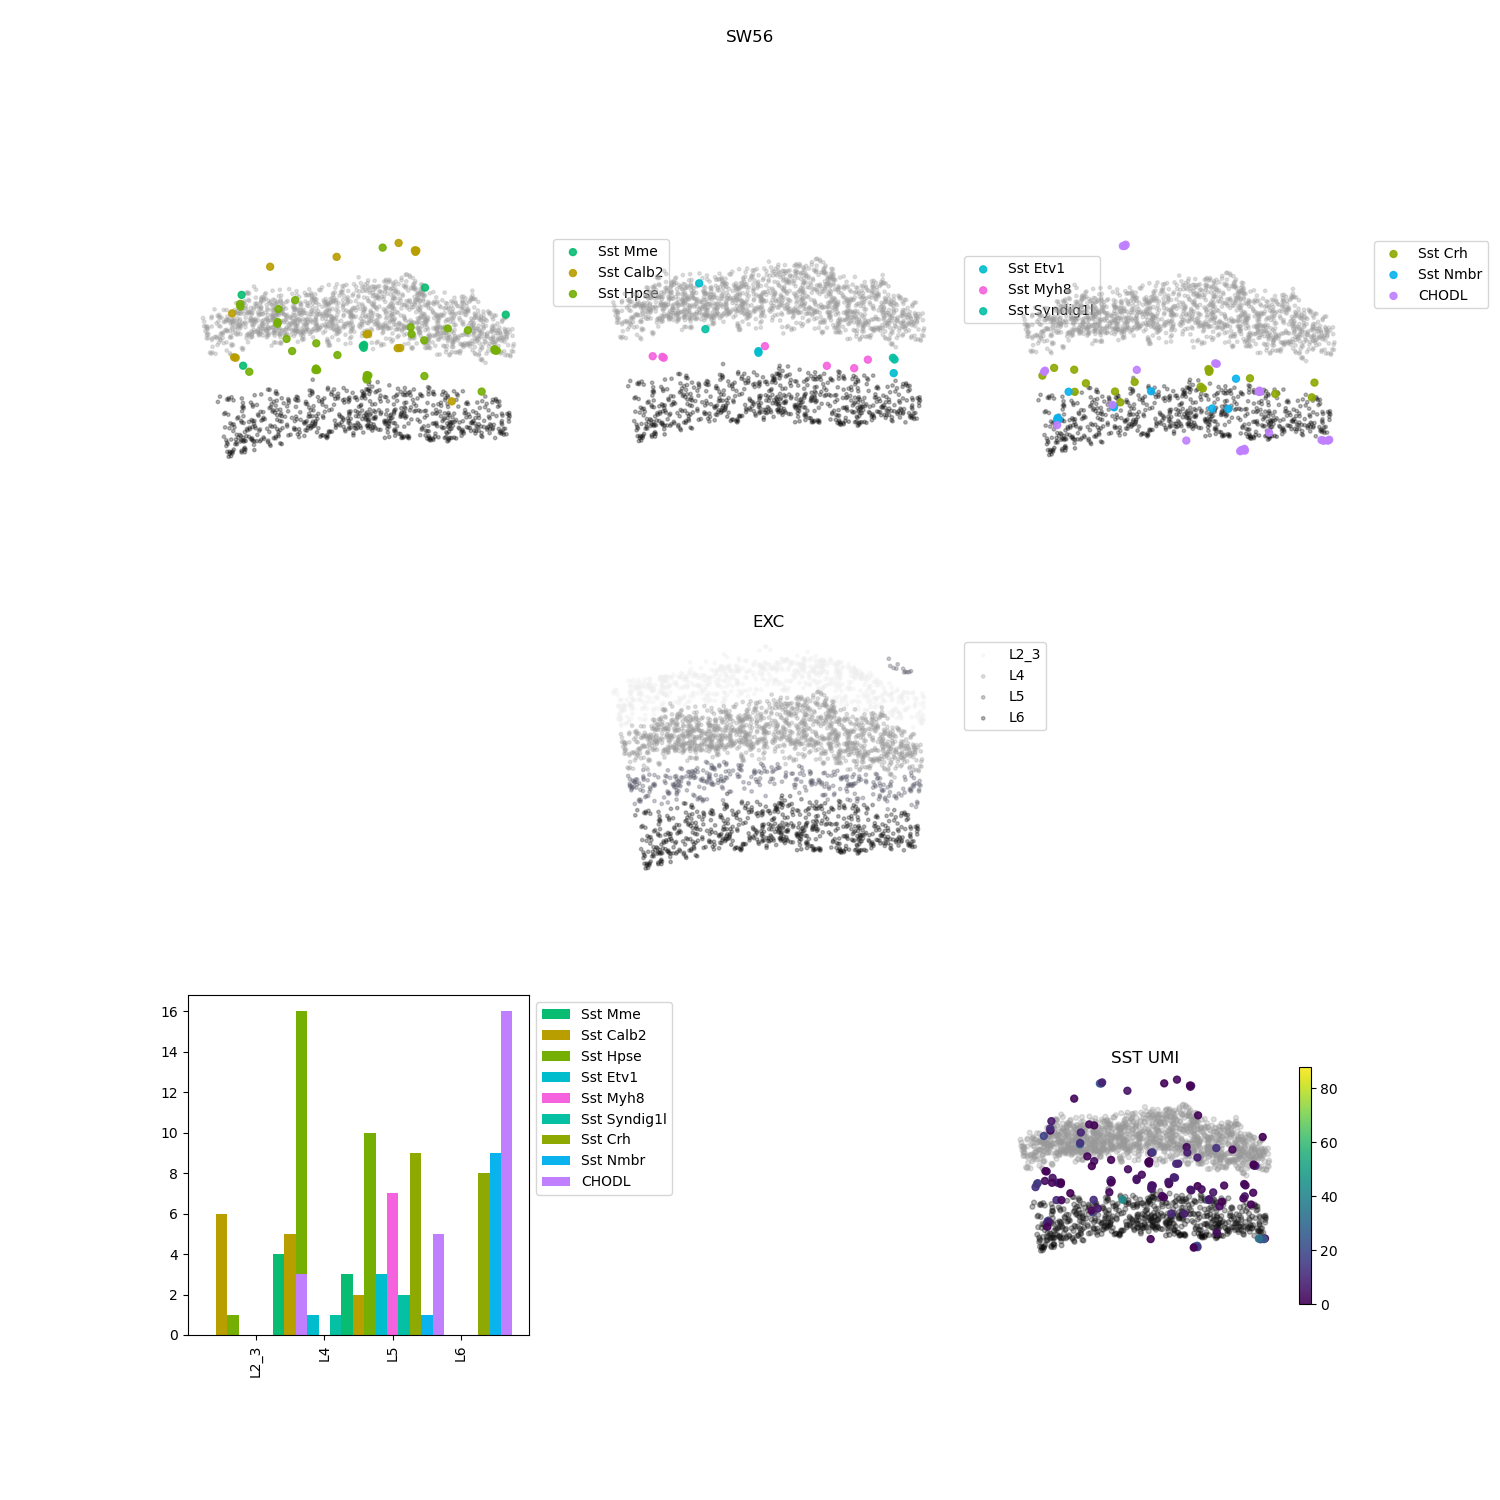

In [20]:
cs = 3
rs = 3
sst_order = ['Sst Mme', 'Sst Calb2','Sst Hpse', 'Sst Etv1','Sst Myh8','Sst Syndig1l', 'Sst Crh','Sst Nmbr','CHODL']
rot_a = {'SW6': -120,'SW55':135, 'SW31':-10, 'SW30':-90, 'F03':-180, 'SW56':-40, 'SW33' :-85}
plt.rcParams["figure.figsize"] = (15,15)
exc_s = 6
for p in pucks.keys():
#     if p != 'SW6':
#         continue
    plt.figure()
    exc = excs[p]
    exc = exc[exc.index.isin(pucks[p].index[pucks[p].sel.eq(1)])]
    sst_pl = sst_pls[p]
    sst_pl = sst_pl[sst_pl.index.isin(pucks[p].index[pucks[p].sel.eq(1)])]

    sst_pl.id = sst_pl.id.astype("category")
    sst_pl.id = sst_pl.id.cat.set_categories(sst_order, ordered=True)
    exc.L = exc.L.replace('L6b','L6')
    exc.L = exc.L.replace('L2','L2_3')
    exc.L = exc.L.replace('L4_5','L4')
    exc.L = exc.L.replace('L5_6','L5')
    exc.L = exc.L.astype("category")
    exc.L = exc.L.cat.set_categories(['L2_3','L4','L5','L6'], ordered=True)

    plt.suptitle(p)
    inc = 0 
    for n, ct in enumerate(sst_pl.id.cat.categories):
        if n%3 ==0:
            ax = plt.subplot(rs, cs, inc + 1)
            inc += 1

            for e in excl:
                tpl = exc[exc.L.eq(e) & exc.mark.eq(1)]
                tpl = rotate_plot(tpl, rot_a[p])
                ax.scatter(x=tpl.rx, y=tpl.ry,s=exc_s,c=tpl.c,alpha=.3)

        tpl = sst_pl[sst_pl.id.eq(ct)]
        tpl = rotate_plot(tpl, rot_a[p])
        ax.scatter(x=tpl.rx, y=tpl.ry,s=25,c=tpl.c,alpha=.9, label = ct)
    #     ax.set_title(ct)
        ax.axis('scaled')
        ax.axis('off')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    ax = plt.subplot(rs, cs, 5)
    for e in exc.L.cat.categories.values:
        tpl = exc[exc.L.eq(e) & exc.mark.eq(1)]
        tpl = rotate_plot(tpl, rot_a[p])
        ax.scatter(x=tpl.rx, y=tpl.ry,s=exc_s,c=tpl.c,alpha=.3, label = e)
        ax.set_title('EXC')
        ax.axis('scaled')
        ax.axis('off')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


    ax = plt.subplot(rs, cs, 7)
    tmppl = sst_pl
    tmppl.L = tmppl.L.replace('L6b','L6')
    tmppl = pd.crosstab(tmppl.L, tmppl.id)
    tmppl.plot(kind='bar',stacked=False, ax=ax, color = sst_scheme,width=1.5)
    ax.legend(bbox_to_anchor=(1,1), loc="upper left")
    ax.set_xlabel('')


    sst_pl['Sst_umi'] = 0
    tf = pucks[p][pucks[p].index.isin(sst_pl.index)].Sst_umi
    sst_pl.loc[tf.index,'Sst_umi'] =  tf.values

    sstu = pldfs[p][pldfs[p].Sst_umi.ge(1)]

    ax = plt.subplot(rs, cs, 9)

    for e in excl:
        tpl = exc[exc.L.eq(e) & exc.mark.eq(1)]
        tpl = rotate_plot(tpl, rot_a[p])
        ax.scatter(x=tpl.rx, y=tpl.ry,s=12,c=tpl.c,alpha=.3, label = e)

    tpl = sst_pl
    tpl = rotate_plot(tpl, rot_a[p])
    neg = ax.scatter(x=tpl.rx, y=tpl.ry,s=25,c=tpl.Sst_umi,alpha=.9, label = 'SST UMI',cmap='viridis')
    ax.set_title('SST UMI')
    ax.axis('scaled')
    ax.axis('off')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)

#     plt.tight_layout()

#     plt.savefig('./FIGURES/{}_{}_{}_{}.pdf'.format('JUN23',p,'smrt','sst_L'))

In [19]:
for p in pldfs:
    pldfs[p] = pldfs[p].assign(Sst_umi=0)
    pldfs[p].Sst_umi[pldfs[p].index.isin(sst_pl.index)] = pucks[p][pucks[p].index.isin(sst_pl.index)].Sst_umi



/tmp/ipykernel_60188/2041008101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pldfs[p].Sst_umi[pldfs[p].index.isin(sst_pl.index)] = pucks[p][pucks[p].index.isin(sst_pl.index)].Sst_umi
/tmp/ipykernel_60188/2041008101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pldfs[p].Sst_umi[pldfs[p].index.isin(sst_pl.index)] = pucks[p][pucks[p].index.isin(sst_pl.index)].Sst_umi
/tmp/ipykernel_60188/2041008101.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [21]:
plt.close('all')

In [22]:
# print(pldfs['SW6'][pldfs['SW6'].my_t.eq('SST')].shape)
for p in sst_pls.keys():
    sst_pls[p] = sst_pls[p].assign(puck=p)
#     sst_pls[p].index[]
#     sst_pls[p] = sst_pls[p].assign(sel=sst_pls[p])
    sst_pls[p] = sst_pls[p][sst_pls[p].index.str.replace('_1','').isin(selbc[p])]
# sst_pls[p][sst_pls[p].index.isin(selbc[p])]
# p='SW6'



In [66]:
boxer = pd.concat([sst_pls[p][['puck','id','L']] for p in sst_pls.keys()])
boxer
# boxer = [sst_pls[p]['id'].value_counts() for p in sst_pls.keys()]
# boxer = pd.crosstab(boxer.puck,boxer.id)
# pd.DataFrame(boxer)
boxer.to_csv('../boxer_3.csv')

In [ ]:
# boxer = pd.concat([sst_pls[p][['puck','id','L']] for p in sst_pls.keys()])
# boxer[['id','L']].groupby(['id','L']).value_counts()
# import seaborn as sns
sns.heatmap(pd.crosstab(boxer.id,boxer.L))
plt.show()

In [67]:
boxer = pd.crosstab(boxer.id,boxer.L)

In [90]:
# sns.violinplot(boxer.id, boxer.L)
# pd.DataFrame(boxer)
# pd.melt(boxer.reset_index(), id_vars='id', var_name=['id','L2_3','L4'])
# boxer.reset_index()
# pd.melt(boxer,id_vars=['id'])
# sns.violinplot(boxer.loc['CHODL'],boxer.index,boxer)


ValueError: Grouper and axis must be same length

In [85]:
plt.close('all')

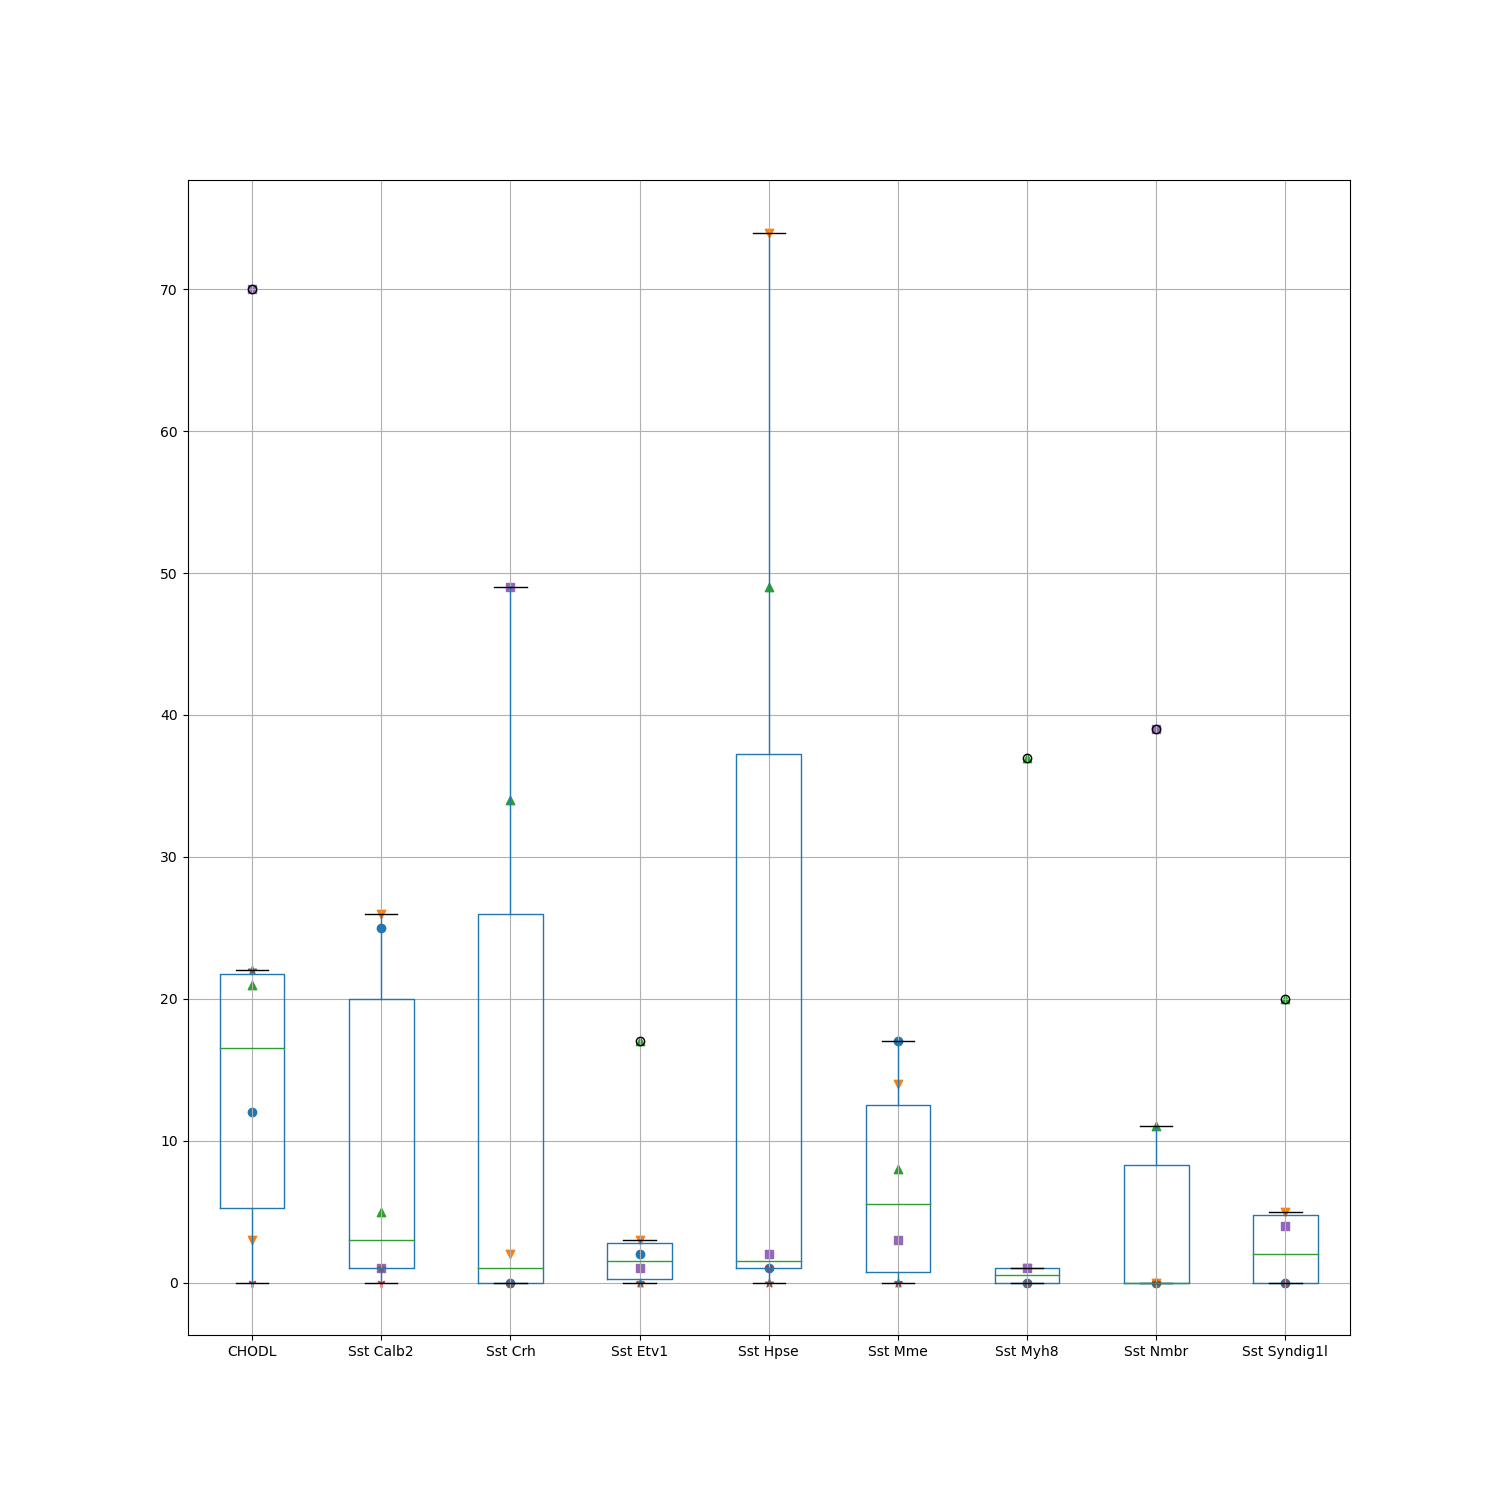

In [40]:
# boxer.boxplot()
plt.close('all')
# plt.figure()

# boxer.columns
# boxer.index

# sn.boxplot(x='puck',y=['CHODL','Sst Calb2','Sst Crh','Sst Etv1','Sst Hpse','Sst Mme','Sst Myh8','Sst Nmbr','Sst Syndig1l'] ,data=boxer)
# ax = sns.swarmplot(x="day", y="total_bill", data=tips, color=".25")
# sn.swarmplot(boxer)
boxer =  pd.crosstab(boxer.L,boxer.id)
ax = boxer.boxplot()
ix = 0
marks =['o','v','^','1','s','*','d']
for ct in boxer.index:
    ax.scatter(x=range(1,10),y=boxer.loc[ct],marker=marks[ix],)

    ix+=1
# plt.xlabel(boxer.columns.values)
plt.show()

